In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py
from mpl_toolkits import mplot3d

from cca.synth_data import embedded_lorenz_cross_cov_mats, oscillators_dynamics_mat, oscillators_cross_cov_mats, sample_oscillators

import cca.synth_data

In [2]:
def gen_heatmap(cross_cov_mats, N_theta=100):
    N_phi = 2*N_theta
    theta = np.linspace(0, np.pi, N_theta)
    phi = np.linspace(0, 2*np.pi, N_phi)
    
    heatmap = np.zeros((N_theta, N_phi))
    
    def pi_val(theta, phi):
        x = np.cos(phi)*np.sin(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(theta)
        v = np.array([x, y, z]).reshape((3, 1))
        pi = cca.cov_util.calc_pi_from_cross_cov_mats(cross_cov_mats, proj=v)
        return pi
    
    for theta_idx in range(N_theta):
        for phi_idx in range(N_phi):
            pi = pi_val(theta[theta_idx], phi[phi_idx])
            heatmap[theta_idx, phi_idx] = pi
            
    return heatmap

def find_local_maxima_2d(Z, tol=1e-6):
    peaks = []
    n_i, n_j = Z.shape
    for i in range(n_i):
        for j in range(n_j):
            if i in [0, n_i-1] or j in [0, n_j-1]:
                continue
            val = Z[i, j]
            patch = Z[i-1:i+2, j-1:j+2].flatten()
            if val > np.max(patch[:4]) + tol and val > np.max(patch[5:]) + tol:
                peaks.append([i, j])
    return peaks

def find_global_maxima_2d(Z, tol):
    local_maxima = find_local_maxima_2d(Z)
    max_val = np.max( [Z[i,j] for (i,j) in local_maxima] )
    peaks = []
    for (i, j) in local_maxima:
        if np.abs(Z[i, j] - max_val) <= tol:
            peaks.append([i, j])
    return peaks


def disp_heatmap(ax, heatmap, show_xlabels=True, show_ylabels=True, title=None):
    N_theta, N_phi = heatmap.shape
    im = ax.imshow(heatmap, origin="lower left", cmap="gray")
    if show_xlabels:
        ax.set_xlabel("$\phi$", fontsize=16, labelpad=-3)
        ax.set_xticks([0, N_phi/2, N_phi-1])
        ax.set_xticklabels(["0", "$\pi$", "$2\pi$"], fontsize=14)
    else:
        ax.set_xticks([])
    if show_ylabels:
        ax.set_ylabel("$\\theta$", fontsize=16, labelpad=-10)
        ax.set_yticks([0, N_theta-1])
        ax.set_yticklabels(["0", "$\pi$"], fontsize=14)
    else:
        ax.set_yticks([])

    peaks = find_local_maxima_2d(heatmap)
    vals_at_peaks = np.array([heatmap[i,j] for (i,j) in peaks])
    
    global_maxima = find_global_maxima_2d(heatmap, tol=0.01)
    if len(global_maxima) == 1:
        #add reflection...
        pt = global_maxima[0]
        if pt[1] < N_phi/2:
            pt_refl = (N_theta - pt[0], pt[1] + N_phi/2)
        else:
            pt_refl = (N_theta - pt[0], pt[1] - N_phi/2)
        global_maxima = [pt, pt_refl]
                
    for (i, j) in peaks:
        if (i, j) in global_maxima:
            continue
        ax.scatter(j, i, s=15, color="red")
        
    for (i, j) in global_maxima:
        ax.scatter(j, i, s=40, marker="X", color="blue")
    
    ax.set_xlim([0, heatmap.shape[1]-1])
    ax.set_ylim([0, heatmap.shape[0]-1])
        
    #cbar = fig.colorbar(im, ax=ax)
    if title is not None:
        ax.set_title(title, fontsize=12)
    #cbar.set_label('PI [bits]', rotation=90, fontsize=14, labelpad=10)
    
    return vals_at_peaks



In [70]:
lorenz_cross_cov_mats = embedded_lorenz_cross_cov_mats(N=3, T=30)

In [106]:
A = oscillators_dynamics_mat(N=10)
osc_cross_cov_mats = oscillators_cross_cov_mats(A, T=6)[:, :3, :3]

[[11, 53], [12, 50], [13, 48], [17, 17], [17, 83], [32, 34], [32, 66], [38, 3]]


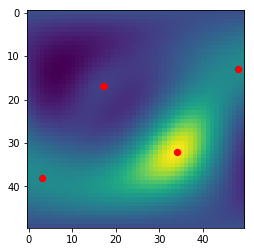

In [107]:
N_theta = 50
heatmap = gen_heatmap(osc_cross_cov_mats, N_theta=N_theta)
peaks = find_local_maxima_2d(heatmap, tol=0)

plt.imshow(heatmap[:, :heatmap.shape[1] // 2])
#plt.colorbar()
print(peaks)
for pt in peaks:
    if pt[1] < heatmap.shape[1]//2:
        plt.scatter(pt[1], pt[0], c="red", s=40)


In [290]:
cross_cov_mats[1]

array([[ 0.4608358 ,  0.60978925,  0.00261494],
       [ 0.19776543,  0.28169344,  0.0049595 ],
       [ 0.00434419,  0.0185978 , -0.33902782]])

In [58]:
R = scipy.stats.ortho_group.rvs(3)
A = scipy.linalg.orth(np.eye(3) - np.dot(R, R.T))

np.linalg.matrix_rank(A)
print(A.shape)

(3, 3)


In [57]:
np.eye(3) - np.dot(R, R.T)

array([[ 5.55111512e-16, -7.11524830e-17, -6.00131945e-17],
       [-7.11524830e-17,  1.11022302e-16, -1.20829896e-16],
       [-6.00131945e-17, -1.20829896e-16,  0.00000000e+00]])